
# 1. Defining the problem statement
Complete the analysis of what sorts of people were likely to survive.
In particular, we ask you to apply the tools of machine learning to predict which passengers survived the Titanic tragedy.


In [390]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 2. Collecting the data

In [391]:
# 주어진 데이터를 훈련하기 위해 데이터를 download\
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub_df = pd.read_csv('gender_submission.csv')

# 3. EDA(Exploratory Data Analysis) & Data Preprocessing
## df :데이터 셋 확인
* shape(row*col), info():피쳐이름,타입 ,  head():데이터샘플

In [392]:
train.shape
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 결측치 처리 (Missing value treatment)
### NaN null nan np.nan

In [393]:
train_test = train.append(test)
nan_dict = {"CNT":train_test.isna().sum(),
            "RATE": train_test.isna().sum()/train.shape[0] *100
}
nan_df = pd.DataFrame(nan_dict)
print(nan_df[nan_df["RATE"]>0].sort_values("CNT", ascending=False))


           CNT        RATE
Cabin     1014  113.804714
Survived   418   46.913580
Age        263   29.517396
Embarked     2    0.224467
Fare         1    0.112233


### Cabin : U0

In [394]:
# print(train["Cabin"].head())
print(train_test["Cabin"].describe())   #[nan 'C85' 'C123' 'E46' 'G6']
train["Cabin"].fillna("", inplace=True)
test["Cabin"].fillna("", inplace=True)

train["Cabin_title"] = train["Cabin"].str[:1]
test["Cabin_title"] = test["Cabin"].str[:1]

count             295
unique            186
top       C23 C25 C27
freq                6
Name: Cabin, dtype: object


In [395]:
cross = pd.crosstab(train["Cabin_title"], train["Survived"])
print(cross)

Survived       0    1
Cabin_title          
             481  206
A              8    7
B             12   35
C             24   35
D              8   25
E              8   24
F              5    8
G              2    2
T              1    0


In [396]:
cross = pd.crosstab(train["Cabin_title"], train["Pclass"])
print(cross)

Pclass        1    2    3
Cabin_title              
             40  168  479
A            15    0    0
B            47    0    0
C            59    0    0
D            29    4    0
E            25    4    3
F             0    8    5
G             0    0    4
T             1    0    0


<pre>
객실 title은 Pclass=1 이 대부분
2~3에 해당 사항없음
결측 처리 대상에서 제외 - 해당 피쳐 삭제

### Age : 이름 호칭별 그룹 평균

* 나이 분포 확인

In [397]:
print(train["Age"].describe())

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


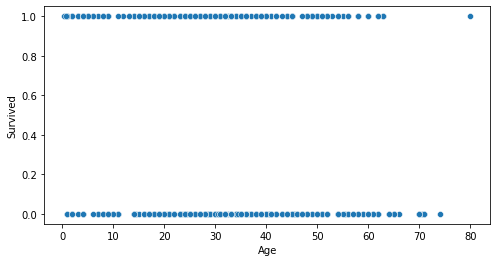

In [398]:
plt.figure(figsize=(8,4))
sns.scatterplot(x="Age", y="Survived", data=train);

* 이름의 호칭을 사용해 평균 나이로 결측 처리

In [399]:
train['Name_title'] = train['Name'].str.extract(' ([A-Za-z]+)\.')
test['Name_title'] = test['Name'].str.extract(' ([A-Za-z]+)\.')
print(test['Name_title'].unique())
print(train['Name_title'].unique())


['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']
['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']


In [400]:
temp_data = pd.concat([train['Name_title'], test['Name_title']])
print(type(temp_data))   #<class 'pandas.core.series.Series'>
temp_data.value_counts()  #1300 , Mr          757  500
# print(temp_data.shape)

<class 'pandas.core.series.Series'>


Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Mlle          2
Major         2
Ms            2
Jonkheer      1
Dona          1
Sir           1
Lady          1
Countess      1
Mme           1
Capt          1
Don           1
Name: Name_title, dtype: int64

In [401]:
name_title_dict = {
'Mr':1,
'Mrs':2, 'Mme':2,
'Miss':3, 'Lady':3, 'Ms' :3,'Mlle':3,
'Master':4 ,
    'Don':5 , 'Dona':5, 'Rev':6 , 'Dr':7 , 'Major':8 ,
 'Sir':9, 'Col':10, 'Capt':11, 'Countess':12, 'Jonkheer':13
}
train['Name_title'] = train['Name_title'].map(name_title_dict)
test['Name_title'] = test['Name_title'].map(name_title_dict)
print(train['Name_title'].head())


0    1
1    2
2    3
3    2
4    1
Name: Name_title, dtype: int64


In [402]:
train["Age"].fillna(train.groupby("Name_title")["Age"].transform("mean"), inplace=True)
test["Age"].fillna(test.groupby("Name_title")["Age"].transform("mean"), inplace=True)
print(train["Age"].unique())

[22.         38.         26.         35.         32.36809045 54.
  2.         27.         14.          4.         58.         20.
 39.         55.         31.         35.78899083 34.         15.
 28.          8.         19.         22.02       40.         66.
 42.         21.         18.          3.          7.         49.
 29.         65.         28.5         5.         11.         45.
  4.57416667 17.         32.         16.         25.          0.83
 30.         33.         23.         24.         46.         59.
 71.         37.         47.         14.5        70.5        32.5
 12.          9.         36.5        51.         55.5        40.5
 44.          1.         61.         56.         50.         36.
 45.5        20.5        62.         41.         52.         63.
 23.5         0.92       43.         60.         10.         64.
 13.         48.          0.75       53.         57.         80.
 70.         24.5         6.          0.67       30.5         0.42
 34.5        74.   

* 파생변수 : 이름의 호칭 카테고리화

In [403]:
# train['T_MR'] = train['Name_title']==Mr 1  0
train["T_MR"] = train["Name_title"].apply(lambda x:  1 if x == "Mr" else 0)
test["T_MR"] = test["Name_title"].apply(lambda x:  1 if x == "Mr" else 0)
test["T_MR"][:5]

0    0
1    0
2    0
3    0
4    0
Name: T_MR, dtype: int64

### Embarked      : 최빈도

In [404]:
temp_data = pd.concat([train['Embarked'], test['Embarked']])
temp_data.describe()

count     1307
unique       3
top          S
freq       914
Name: Embarked, dtype: object

In [405]:
print(train["Embarked"].unique())

['S' 'C' 'Q' nan]


In [406]:
mode_value = train["Embarked"].mode()
print(mode_value, type(mode_value))
# train["Embarked"] = train["Embarked"].fillna(mode_value) # , inplace=True)
# test["Embarked"] = test["Embarked"].fillna(mode_value) #  , inplace=True)

0    S
dtype: object <class 'pandas.core.series.Series'>


In [407]:
mode_value = 'S'
train["Embarked"].fillna(mode_value, inplace=True)
test["Embarked"].fillna(mode_value, inplace=True)
# train["Embarked"] = train["Embarked"].replace(np.nan, 'S')
# test["Embarked"] = test["Embarked"].replace(np.nan, 'S')

In [408]:
print(train["Embarked"].unique())

['S' 'C' 'Q']


### Fare : 0

In [409]:
train["Fare"].fillna(0, inplace=True)
test["Fare"].fillna(0, inplace=True)

## -- family name, Ticket,   T_family = (SibSp+Parch)+1  > 2
   - Survived 생존률 rate 가중치 부여

In [410]:
print(train.isna().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Cabin_title    0
Name_title     0
T_MR           0
dtype: int64


In [411]:
print(test.isna().sum())

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Cabin_title    0
Name_title     0
T_MR           0
dtype: int64


# 4. Feature Converting  -- T......Engineering

In [412]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
 12  Cabin_title  891 non-null    object 
 13  Name_title   891 non-null    int64  
 14  T_MR         891 non-null    int64  
dtypes: float64(2), int64(7), object(6)
memory usage: 104.5+ KB


<pre>
--------------------------------------------- 
5   Age          714 non-null    float64 -- Name_title평균나이, T_MR:0,1
10  Cabin        204 non-null    object -- 삭제
11  Embarked     889 non-null    object -- 'S' 최빈값
---------------------------------------------
3   Name         891 non-null    object -- 삭제
4   Sex          891 non-null    object -- m:1 f:0
8   Ticket       891 non-null    object -- 삭제
10  Cabin        204 non-null    object -- 삭제
*   Cabin_title  204 non-null    object -- 삭제
11  Embarked     889 non-null    object -- S:1~2
----------------------------------------------
T_family = (SibSp+Parch)+1

### Object 타입 numeric화

In [413]:
# train.select_dtypes(include='object')

In [414]:
train[["Embarked","Sex"]].describe()

,Embarked,Sex
count,891,891
unique,3,2
top,S,male
freq,646,577


In [415]:
# temp = pd.concat([train, test])
train_test = [train, test]
for df in train_test:
#   1. map
    sex_dict = {'male':1,'female':0}
    df['T_sex'] = df['Sex'].map(sex_dict)
    
    emb_dict = {'Q':0 , 'S':1 , 'C':2}
    df['T_embarked'] = df['Embarked'].map(emb_dict)

    df["T_family"] = (df["SibSp"] + df["Parch"]) + 1
#     print(train['T_sex'].head())
    
#     2. lambda
#     train["T_sex2"] = train["Sex"].apply(lambda x:  1 if x == "male" else 0)
#     print(train['T_sex'].head())
    
#     3. replace
#     train["T_sex3"] = train["Sex"].replace('male', 1)
#     train["T_sex3"] = train["T_sex3"].replace('female', 0)
#     print(train['T_sex3'].head())

In [416]:
train[['T_embarked','Embarked']].head()

,T_embarked,Embarked
0,1,S
1,2,C
2,1,S
3,1,S
4,1,S


In [417]:
#--------------------------------------------------------------------
# 4. get_dummy() : DataFrame  ,  retrun DataFrame --> DataFrame
#--------------------------------------------------------------------
# dummy_df = pd.get_dummies(train["Sex"])
# # train = pd.concat(train,dummy_df)
# train = train.join(dummy_df)
# print(train.info())

In [418]:
# train[["Sex","female","male"]].head()

In [419]:
#--------------------------------------------------------------------
# Encoder : like array  ,  retrun like array --> DataFrame
#--------------------------------------------------------------------
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from scipy.sparse import csr_matrix

# le_encoder = LabelEncoder()
# #train[["Sex","Embarker"]] = encoder.fit_transform(train[["Sex","Embarker"]])   XXXXXX
# cols = ["Sex",]
# for col in cols:   
#     train["LE_"+col] = le_encoder.fit_transform(train[col])
#     print(train[["Sex", "LE_Sex"]].head())
# #     print(np.array(train["LE_"+col]).reshape(-1, 1))
#     oh_encoder = OneHotEncoder()    
#     res = oh_encoder.fit_transform(np.array(train["LE_"+col]).reshape(-1, 1))   #[[],[],[]]
#     print(type(res), res.shape)
    
#     csr_df = pd.DataFrame.sparse.from_spmatrix(res, columns=['OH_M', 'OH_F'])  
    
# train = train.append(csr_df)
# # dtype = pd.SparseDtype(np.float64, fill_value=0)
# # train['OH_M'].astype(dtype)
# train.info()

In [420]:
#--------------------------------------------------------------------
# Encoder : like array  ,  retrun like array --> like array
#--------------------------------------------------------------------
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# item = ["b","a","c","d","e","f","g"]
# encoder = LabelEncoder()  #글자-->숫자
# # encoder.fit(item)
# # res = encoder.transform(item)
# res = encoder.fit_transform(item)
# print(encoder.classes_)
# print(res)   #[1 0 2 3 4 5 6]
# print(encoder.inverse_transform(res))

# oh_encoder = OneHotEncoder()
# re_res = res.reshape(-1,1)  #------------------[[],[],[],[]]
# res = oh_encoder.fit_transform(re_res)
# print(res.shape)
# print(res)

#-------------------- [LabelEncoder, OneHotEncoder] + 결측처리**
# import pandas as pd
# df = pd.DataFrame({"key" : ["b","a","c","d","e","f","g"]})
# print(df.head())
# df = pd.get_dummies(df["key"])
# print(df.head())

### Float 타입 numeric화

In [421]:
# dataset["Age"] = train_df["Age"].astype(int)

In [422]:
float_features_list = train.dtypes[train.dtypes == 'float64'].index.values
print(float_features_list)
train[float_features_list] = train[float_features_list].astype(np.int32)
test[float_features_list] = test[float_features_list].astype(np.int32)

['Age' 'Fare']


### 불필요한 피쳐 삭제

In [423]:
object_features_list = train.dtypes[train.dtypes == 'object'].index.values
print(object_features_list)

['Name' 'Sex' 'Ticket' 'Cabin' 'Embarked' 'Cabin_title']


In [424]:
train.drop(object_features_list, axis=1, inplace=True)
test.drop(object_features_list, axis=1, inplace=True)

In [425]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  891 non-null    int64
 1   Survived     891 non-null    int64
 2   Pclass       891 non-null    int64
 3   Age          891 non-null    int32
 4   SibSp        891 non-null    int64
 5   Parch        891 non-null    int64
 6   Fare         891 non-null    int32
 7   Name_title   891 non-null    int64
 8   T_MR         891 non-null    int64
 9   T_sex        891 non-null    int64
 10  T_embarked   891 non-null    int64
 11  T_family     891 non-null    int64
dtypes: int32(2), int64(10)
memory usage: 76.7 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Pclass       418 non-null    int64
 2   Age       

In [426]:
train.drop('PassengerId', axis=1, inplace=True)
test.drop('PassengerId', axis=1, inplace=True)

# 모델 선정 및 학습 : 우선 점수부터 확인하고 작업 더 진행

<pre>
모델 분석에 필요한 데이터 종류 : train[train set : validation set] , test set
                                    train_test_split
* classification(분류) 모델선정 : 문제집 선택
* 학습     : fit(문제train8, 정답train_Survived8)
* 모의고사 : predict(모의시험지train2=validation) ----- 예측답안
* 모의채점 : _score(예측답안, 모의고사정답지train2=validation)
*---------------------------------------------------------------------    
* 본시험   : predict(본시험지test)   ----- 예측답안
* 본채점   : _score(예측답안submission, 본시험정답지kaggle-leaderboard)

In [427]:
# ! pip install lightgbm
# ! pip install xgboost

In [428]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# XGBoost python wrapper class
# ref : https://injo.tistory.com/44
# ref : https://velog.io/@dbj2000/ML
import xgboost as xgb ## XGBoost 불러오기

#LightGBM
# ref : https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, recall_score, f1_score, roc_auc_score

* 정확도(Accuracy)
Accuracy = (TP + TN)/(TP + TN + FP + FN)

#### 1. 학습.답안 데이터 셋 분리

In [429]:
train_y = train["Survived"]
train_X = train.drop("Survived", axis=1)
print(train_y.shape, train_X.shape)

(891,) (891, 10)


#### 2..학습'답안/검증'답안 데이터 셋 분리

In [430]:
문제_학습8, 문제_검증2, 답안_학습8, 답안_검증2 = train_test_split(train_X, train_y, test_size=0.2, random_state=121,  shuffle=False)
print(문제_학습8.shape, 문제_검증2.shape, 답안_학습8.shape, 답안_검증2.shape)

(712, 10) (179, 10) (712,) (179,)


In [431]:
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
lr = LogisticRegression()
knn = KNeighborsClassifier()

In [432]:
dt.fit(문제_학습8, 답안_학습8)
내가낸답안2 = dt.predict(문제_검증2)
df_score = accuracy_score(내가낸답안2 ,  답안_검증2)
print(df_score)     # 0.7541899441340782  float 
                    # 0.7653631284916201  int

0.7597765363128491


In [433]:
float_features_list = train.dtypes[train.dtypes == 'float64'].index.values
print(float_features_list)
train[float_features_list] = train[float_features_list].astype(np.int32)
test[float_features_list] = test[float_features_list].astype(np.int32)

[]


# 기초 통계를 활용한 feature 분석

## Feature Inportance

In [434]:
dt.feature_importances_

array([0.10745289, 0.2219288 , 0.00675839, 0.01465737, 0.18404452,
       0.36765988, 0.        , 0.        , 0.03788061, 0.05961754])

In [435]:
imp_df = pd.DataFrame({"feature": train_X.columns, "importance": dt.feature_importances_})
imp_df.sort_values('importance', ascending=False).T

,5,1,4,0,9,8,3,2,6,7
feature,Name_title,Age,Fare,Pclass,T_family,T_embarked,Parch,SibSp,T_MR,T_sex
importance,0.36766,0.221929,0.184045,0.107453,0.059618,0.037881,0.014657,0.006758,0.0,0.0


## Fare 요금을 최소 요금 약 7달러로 구간화

In [436]:
# # 7달러 기준으로 구간화

# def fare_bining(x): #df["Fare"]
#     T_fare = 0
#     if x <= 7:
#         T_fare = 1
#     elif x <= 14:
#         T_fare = 2
#     elif x <= 21:
#         T_fare = 3
#     else:
#         T_fare = 4
#     return T_fare
        
# train_X["T_Fare"] = train_X["Fare"].apply(lambda x: fare_bining(x))

train_X["T_Fare"] = train_X["Fare"].apply(lambda x: x//7)
train_X[["T_Fare", "Fare"]].head(10)

,T_Fare,Fare
0,1,7
1,10,71
2,1,7
3,7,53
4,1,8
5,1,8
6,7,51
7,3,21
8,1,11
9,4,30


In [437]:
def myfit(X, y, imp=0, t_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= t_size, random_state=36,  shuffle=False)
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    dt.fit(X_train, y_train)
    pred = dt.predict(X_test)
    df_score = accuracy_score(pred, y_test)
    print(df_score)
    
    if imp == 1:
        imp_df = pd.DataFrame({"feature": train_X.columns, "importance": dt.feature_importances_})
        imp_df.sort_values('importance', ascending=False).T
                       

In [438]:
myfit(train_X, train_y, 1) # 0.7597765363128491

0.7597765363128491


In [439]:
train_X.drop(["Fare"], inplace=True, axis=1)

In [440]:
myfit(train_X, train_y) # 0.8212290502793296

0.7821229050279329


## Age 구간화